# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

---
## 1. Read the dataset

In [10]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


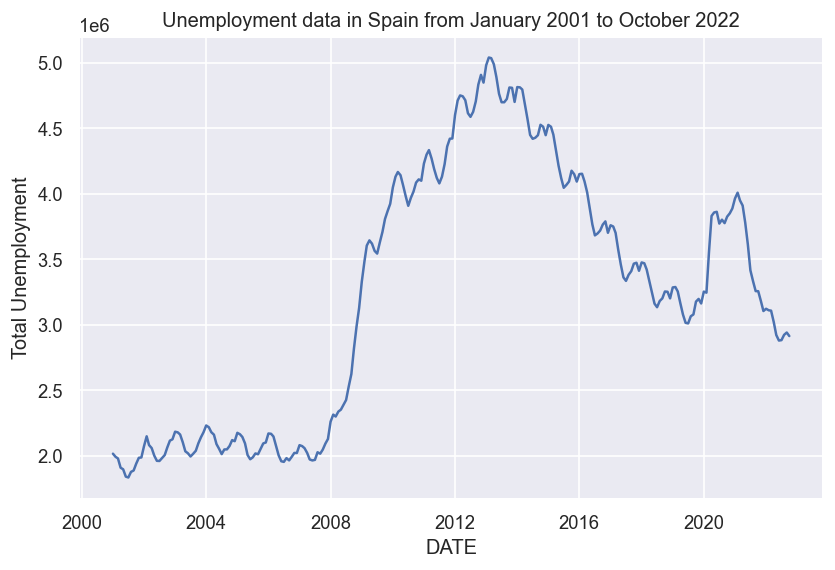

In [11]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2022', xlabel='DATE', ylabel='Total Unemployment')
plt.show()

---
### Identification process

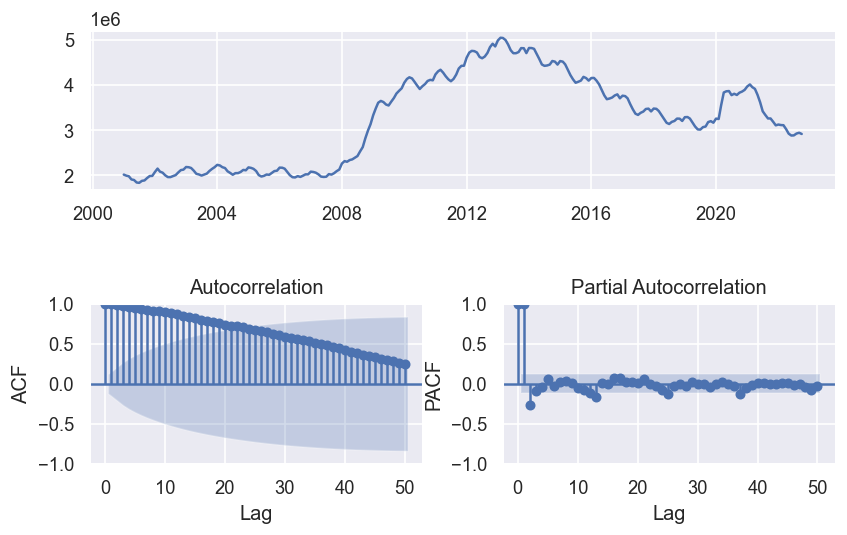

In [12]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df,lags=50)

#### 2. Stabilize the variance (if needed)

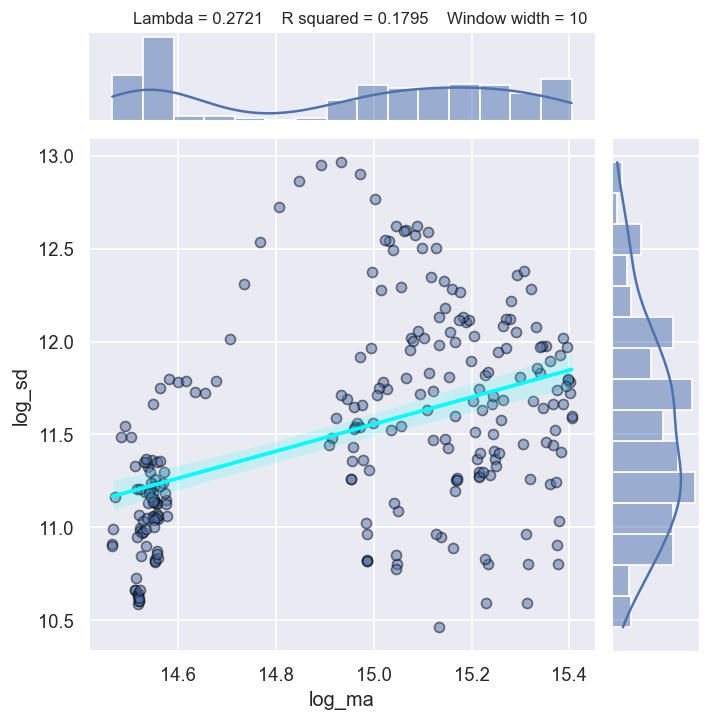

0.27210526664231893

In [13]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df, window_width=10)

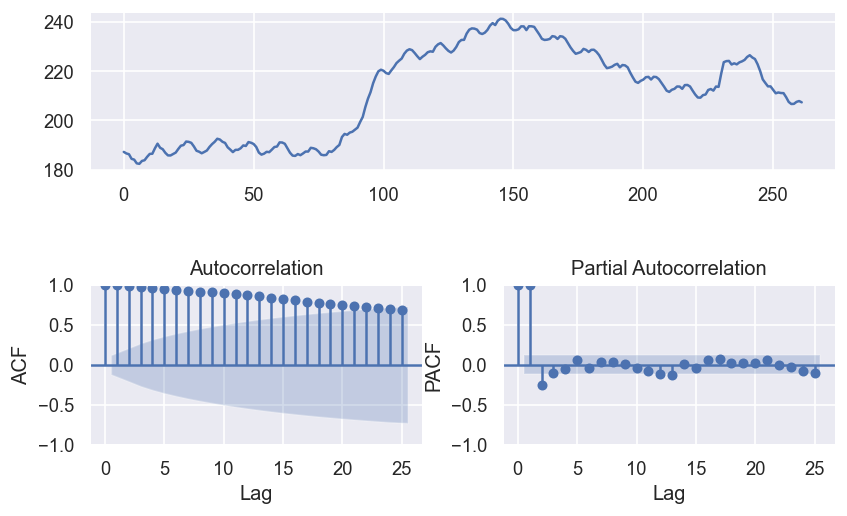

In [60]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.2721 #Select lambda
    z = st.boxcox(df.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df.columns.values.tolist())
else:
    z = df

# Plot transformed data
FT.ts_display(z)

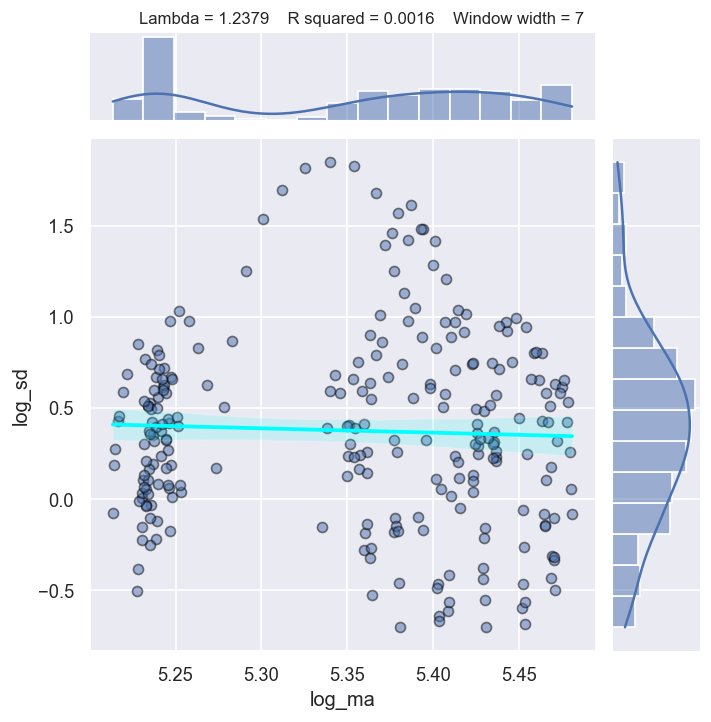

1.23792094650543

In [51]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=7)

#### 3. Analyze stationarity 

In [52]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.826333
p-value: 0.367469
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


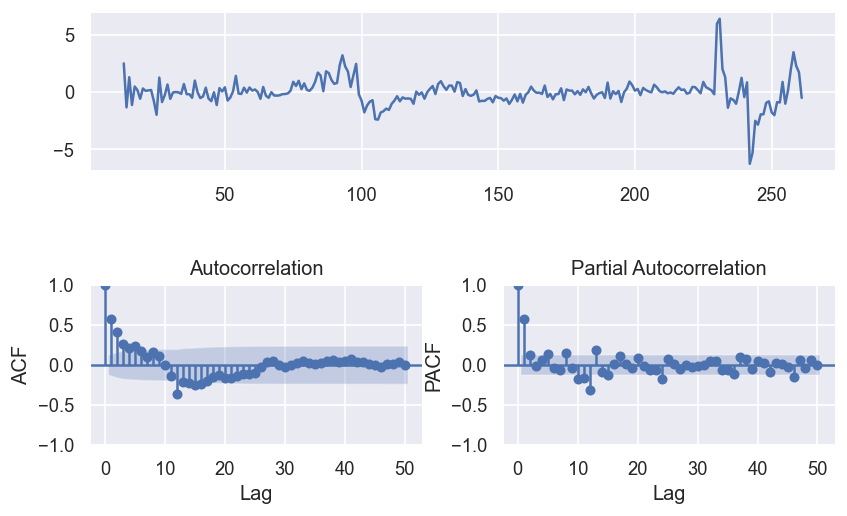

In [61]:
# Difference of the time series
d = 1
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

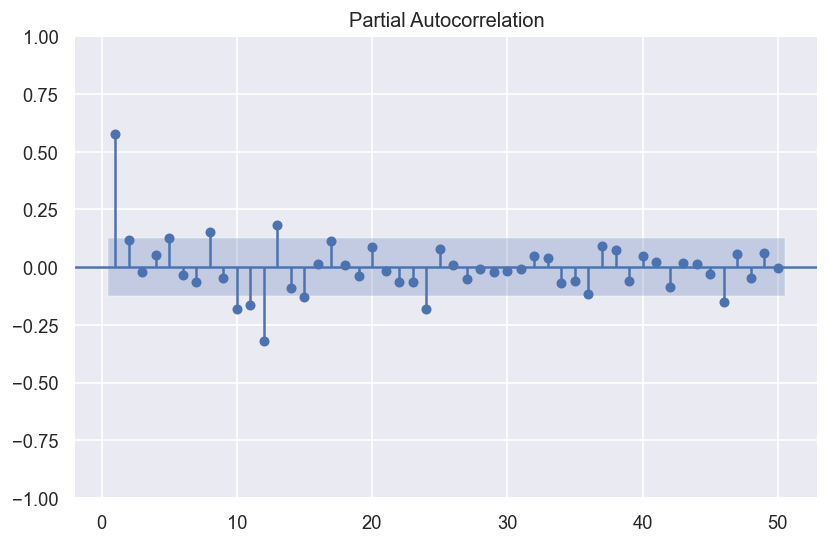

<Figure size 960x600 with 0 Axes>

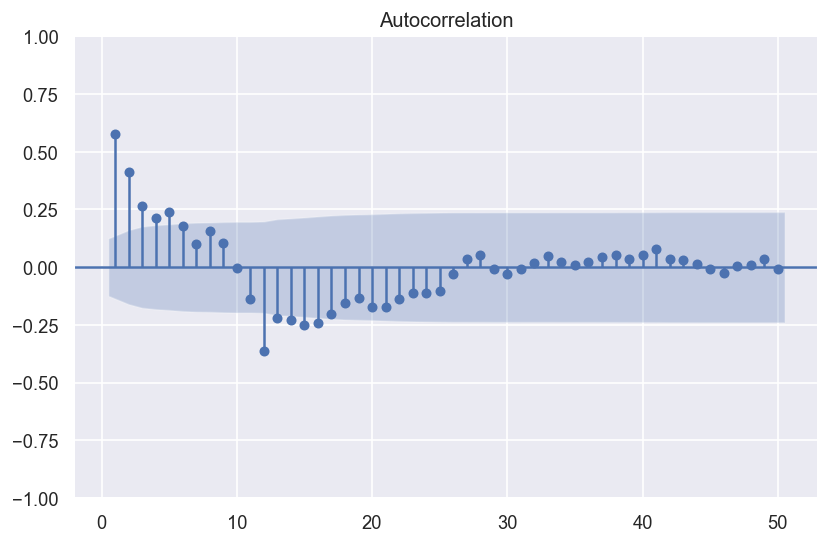

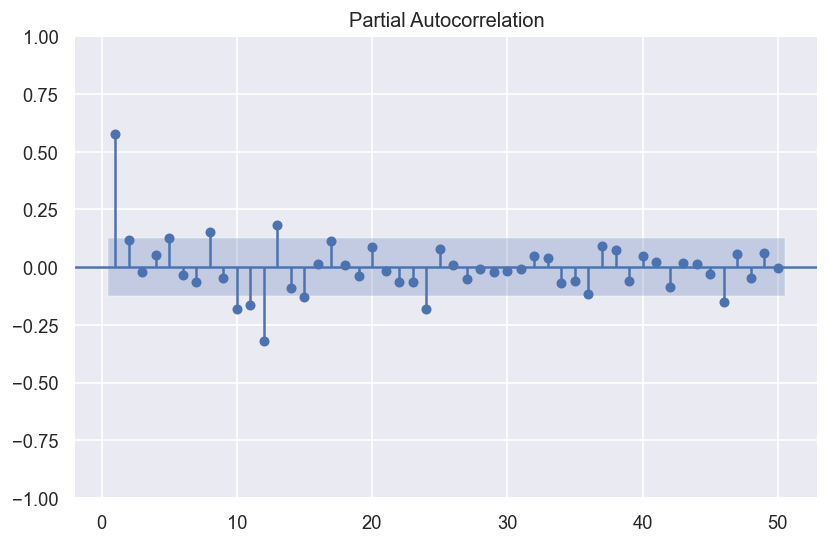

In [62]:
#Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary an autorregresive model (1,1,0) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [78]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -288.770
Date:                              Wed, 22 Nov 2023   AIC                            583.539
Time:                                      10:13:32   BIC                            594.091
Sample:                                           0   HQIC                           587.787
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6474      0.028     23.072      0.000       0.592       0.702
ma.S.L12      -0.85

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.106896   0.837819


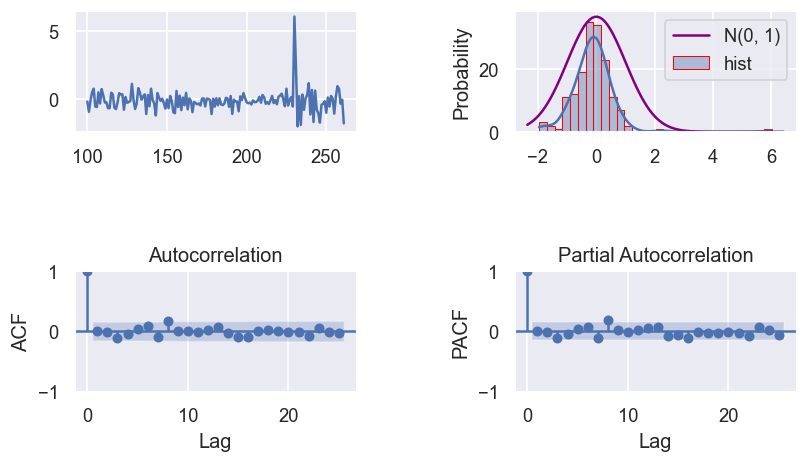

In [79]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))